In [1]:
import os, sys, pickle
import numpy as np
import pandas as pd
import product_fem as pf
import fenics
import json
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt
import maps

In [2]:
#may need to install SLiM in env
seed = 2877096093782 
if not os.path.exists("density_saddle/out_2877096093782.trees"):
    ! slim -s {seed} --define OUTDIR=\"density_saddle\" fecundity_regulation.slim
! python compute_stats.py density_saddle/out_2877096093782.trees 20

Reading in from density_saddle/out_2877096093782.trees, outputting to density_saddle/out_2877096093782_stats
All done with density_saddle/out_2877096093782_stats =) =)


# Parameters for inference

Here are things we might want to adjust.

In [3]:
mesh_n = 5
penalty = 1e-2
epsilon = 0.03

# Read in the data

This reads in:
1. spatial statistics (e.g., average density at a grid of points), from `.spstats.csv`
2. sampling locations and genetic diversities there, from `.stats.csv`
3. pairwise divergences, from `.pairstats.csv`,
4. the parameters, from `params.json`

and also loads the maps used to parameterize the simulation, as images.

In [4]:
# load spatial and genetic data
simbase = "density_saddle/out_2877096093782"
basename = simbase + "_stats/rep205425"
basedir = os.path.split(basename)[0]
basebasedir = os.path.split(simbase)[0]
mapfile = f"{simbase}.spstats.csv"
with open(os.path.join(basedir, "params.json"), "r") as pfile:
    params = json.load(pfile)
    for k in params:
        if len(params[k]) == 1:
            params[k] = params[k][0]
spatial_data = pd.read_csv(f"{basename}.stats.csv", index_col=0)
genetic_data = pd.read_csv(f"{basename}.pairstats.csv", index_col=0)
bias_map = Image.open(params['BIAS_MAP_FILE'])
cov_map = Image.open(params['COVARIANCE_MAP_FILE'])
habitat_map = Image.open(params['HABITAT_MAP_FILE'])
empirical_maps = pd.read_csv(mapfile)
width, height = bias_map.width / params['MAP_RESOLUTION'], bias_map.height / params['MAP_RESOLUTION']
aspect_ratio = width/height
size = (width + height)/2

In [5]:
params

{'BIAS': 0.0,
 'BIAS_MAP_FILE': 'density_saddle/../maps/one.png',
 'COVARIANCE_MAP_FILE': 'density_saddle/../maps/identity.png',
 'HABITAT_MAP_FILE': 'density_saddle/../maps/saddle_height.png',
 'INTERACTION_DISTANCE': 1.0,
 'K': 10,
 'LAMBDA': 3.0,
 'LOGPATH': 'density_saddle/out_2877096093782.log',
 'MAP_RESOLUTION': 20,
 'NUMTICKS': 10000,
 'OUTBASE': 'density_saddle/out_2877096093782',
 'OUTDIR': 'density_saddle',
 'OUTPATH': 'density_saddle/out_2877096093782.trees',
 'SIGMA': 1.0,
 'SURVIVAL': 0.9,
 'seed': 2877096093782}

Here are the images used to parameterize the simulation.

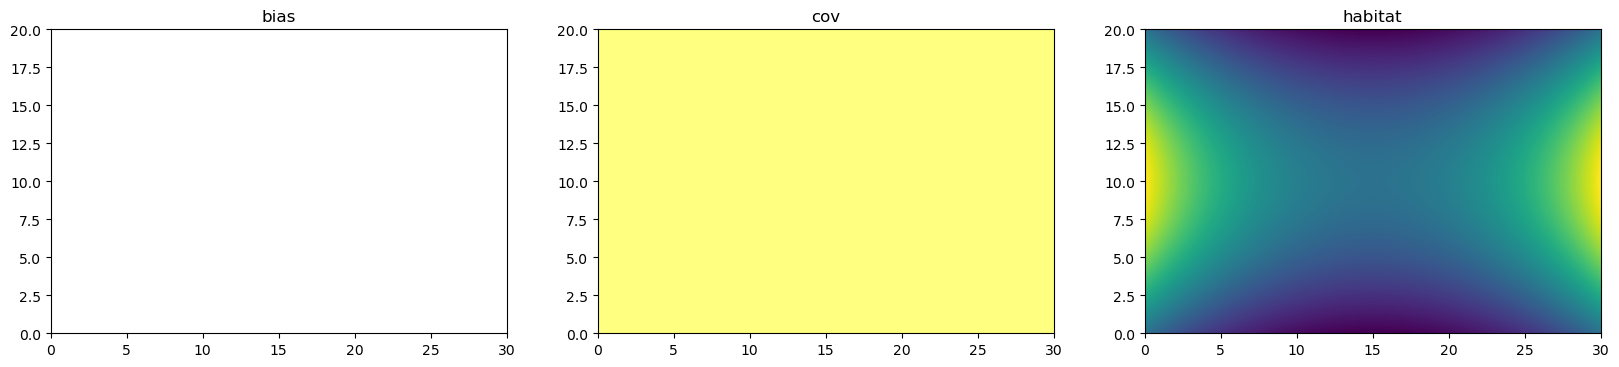

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 9))
for (im, lab), ax in zip(((bias_map, 'bias'), (cov_map, 'cov'), (habitat_map, 'habitat')), axes):
    ax.imshow(im, extent=(0, width, 0, height))
    ax.set_title(lab)

# Empirical maps

Here are the maps of average density, fecundity, and establishment
that SLiM recorded during the simulation.
First some helper functions to pull the information out of the pandas table it is in.

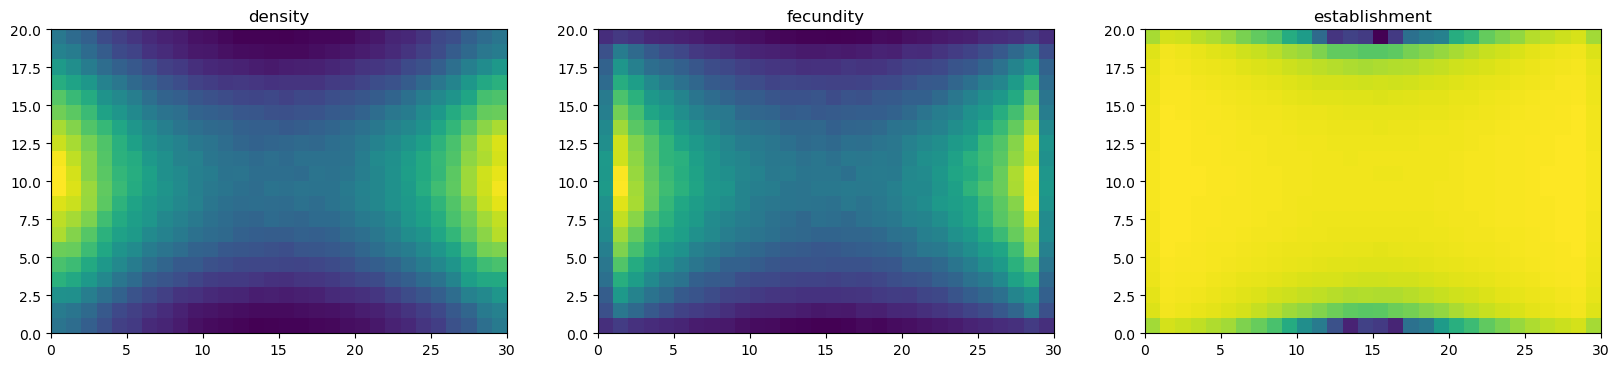

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 9))
for lab, ax in zip(("density", "fecundity", "establishment"), axes):
    _, _, im = maps.xyz_to_array(empirical_maps['x'], empirical_maps['y'], empirical_maps[lab])
    ax.imshow(im, extent=(0, width, 0, height))
    ax.set_title(lab)

Here is some of the data! In this map, circle size is proportional to heterozygosity.

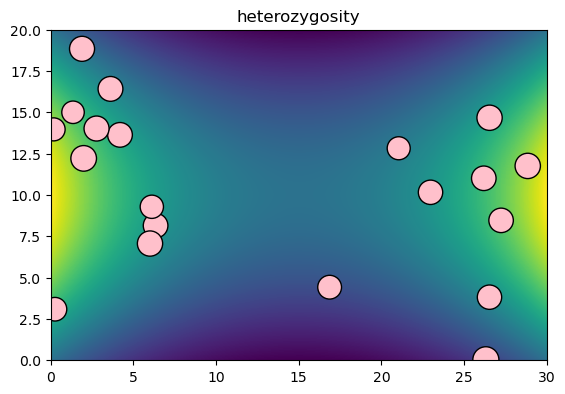

In [8]:
het_scale = 10**(2-np.floor(np.log10(np.max(spatial_data['het']))))
fig, ax = plt.subplots()
ax.imshow(habitat_map, extent=(0, width, 0, height))
ax.scatter(spatial_data['x'], spatial_data['y'], s=spatial_data['het']*het_scale, c='pink', edgecolors='black')
ax.set_aspect(1.0)
ax.set_title(f"heterozygosity");

# Inference

Now, we'll set up for inference: making a mesh,
and normalizing coordinates and data.

In [9]:
scaling = {
    'xy': size,
}

mesh = fenics.RectangleMesh(fenics.Point(0.0, 0.0), fenics.Point(width/scaling['xy'], height/scaling['xy']),
                            int(aspect_ratio * mesh_n), mesh_n)
V = fenics.FunctionSpace(mesh, 'CG', 1)
W = pf.ProductFunctionSpace(V)

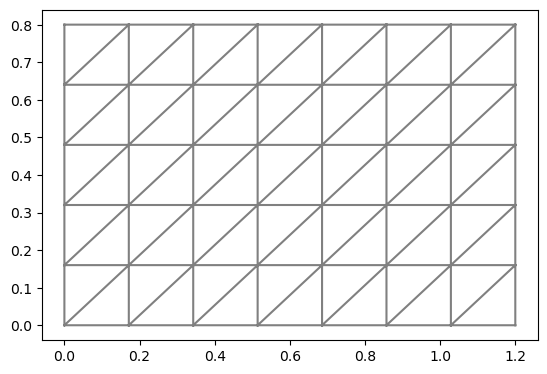

In [10]:
fenics.plot(mesh);

In [11]:
# normalize dxy
train_dxy = genetic_data['divergence'].to_numpy()
scaling['divergence'] = train_dxy.max()
train_dxy /= scaling['divergence']

train_dxy

array([0.71271494, 0.9018179 , 0.98704366, 0.9857105 , 0.75965415,
       0.75488451, 0.77467496, 0.97828099, 0.79687288, 0.91237971,
       0.82334211, 0.80668397, 0.96320194, 0.9840408 , 0.97261825,
       0.99227279, 0.84368265, 0.91168076, 0.92547842, 0.83696503,
       0.83277785, 0.96585533, 1.        , 0.98387901, 0.97943942,
       0.84379267, 0.8530472 , 0.85817278, 0.89466668, 0.97955591,
       0.81523955, 0.82631909, 0.98483682, 0.99250578, 0.97351135,
       0.63611595, 0.97742672, 0.98677185, 0.98642238, 0.67820786,
       0.89323643, 0.73882176, 0.98667478, 0.80234146, 0.98345187,
       0.76128502, 0.72966431, 0.75858632, 0.74337784, 0.73152169,
       0.95895003, 0.9729742 , 0.97553052, 0.7239045 , 0.82591785,
       0.89733949, 0.97160867, 0.75903287, 0.97146629, 0.81777645,
       0.812392  , 0.97123331, 0.64755791, 0.77760017, 0.96164873,
       0.82266259, 0.80169429, 0.96852167, 0.82664915, 0.75817213,
       0.90405711, 0.98705014, 0.80842485, 0.81645623, 0.83462

In [12]:
# pairwise coordinates needed for kernel density estimate
points = spatial_data[['x', 'y']].to_numpy() / scaling['xy']

def coords_to_pairs(points):
    n = len(points)
    N = int(n * (n + 1) / 2)
    xs = np.zeros((N, 2))
    ys = np.zeros((N, 2))
    x1, y1, x2, y2 = [], [], [], []
    for i in range(n):
        for j in range(i, n):
            x1.append(points[:,0][i])
            y1.append(points[:,1][i])
            x2.append(points[:,0][j])
            y2.append(points[:,1][j])

    xs[:,0] = x1
    xs[:,1] = y1
    ys[:,0] = x2
    ys[:,1] = y2
    return xs, ys

We get the boundary conditions as follows.
To estimate $\pi(x)$ for $x \in \mathbb{R}^2$ let for $i \le j$
$$ w_{ij} = \exp\left( - (|x-x_i|^2 + |x_j - x|^2) / 2 \sigma^2_e - |x_i - x_j|^2 / 2 \epsilon^2 \right), $$
where $\sigma_e$ is four times the mean second-nearest-neighbor distance and $\epsilon$ is a parameter.
Then, using the diverences and diversities $d(i, j)$,
get
$$ \hat \pi(x) = \frac{ \sum_{i \le j} d(i, j) w_{ij} }{ \sum_{i \le j} w_{ij} } . $$
Then, for a point $(x, y) \in \mathbb{R}^2 \times \mathbb{R}^2$,
let
$$ \hat d(x, y) = \hat \pi((x+y)/2) . $$

**Note:** the convergence of the solver below can depend on these parameters!
TODO: figure out how to adjust them.

In [13]:
dists = np.sqrt(np.subtract.outer(points[:,0], points[:,0])**2 + np.subtract.outer(points[:,1], points[:,1])**2)
sigma_e = 4 * np.mean(dists[np.arange(20), dists.argsort()[:,2]]) # third-largest, row-wise
xs, ys = coords_to_pairs(points)
def kernl(x, y):
    x = np.add(x, y) / 2
    def _dists(x_i, x_j, x):
        diffs = (x_i - x_j) / epsilon, (x_i - x) / sigma_e, (x_j - x) / sigma_e
        dists = np.sum([np.hypot(*xx) for xx in diffs])
        return dists
    dists = np.array([_dists(x_i, y_i, x) for x_i, y_i in zip(xs, ys)])
    scale = 2 / scaling['xy']**2
    return np.exp(-dists / scale)

def boundary(x, y):
    k = kernl(x, y)
    return (train_dxy * k).sum() / k.sum()

In [14]:
sigma_e

0.6110018523540806

Now we set up and solve the equation.

In [17]:
eqn = pf.HittingTimes(W, boundary, epsilon=epsilon)
control = eqn.control

# loss functionals
reg = {'l2': [100*penalty, 100*penalty], 'smoothing': [penalty, penalty]}
train_sd = pf.SpatialData(train_dxy, points, W)
train_loss = pf.LossFunctional(train_sd, control, reg)

invp = pf.InverseProblem(eqn, train_loss)

ValueError: xy0 and xy1 must have the same shape, and each must have the same length as data.

In [22]:
train_dxy.shape


(210,)

In [ ]:
options = {'ftol': 1e-8, 
           'gtol': 1e-8, 
           'maxcor': 15,
           'maxiter': 100}
m_hats, losses, results = invp.optimize(control, 
                                        method='L-BFGS-B', 
                                        options=options)

3.512466033260392 3.129573328231337 0.38073541446529935 0.002157290563755733
1.612129837381427 1.286605006034848 0.31269460303924335 0.012830228307335559
0.8360993288045955 0.5145247726160247 0.28660492657574904 0.03496962961282166
0.569990525039793 0.24368196634783076 0.26555734447334267 0.06075121421861955
0.431496033225125 0.12287017751124064 0.22221937648951023 0.08640647922437412
0.32315918664322685 0.0676166920404957 0.15730746045482444 0.09823503414790669
0.23316160710383643 0.04735574589293951 0.10513538893079648 0.08067047228010042
0.18491395977554906 0.05006069984477516 0.08243459654823276 0.05241866338254114
0.16371221850413553 0.06423159331779846 0.06863725020271919 0.030843374983617892
0.15590298693487525 0.07571741939669964 0.05791182147743623 0.022273746060739393
0.15479017684495333 0.07642720258232392 0.055853202311807904 0.022509771950821503
0.15419804191182807 0.0753327107848389 0.05534424721816664 0.02352108390882252
0.15391838479337336 0.0749321433068969 0.055142059

In [ ]:
control.update(m_hats[-1])
u_hat = eqn.solve()

Here is an example slice of the 4d solution:

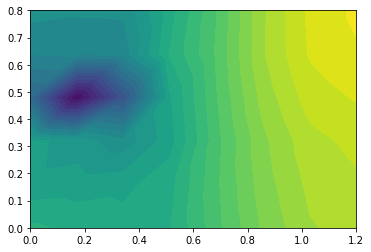

In [ ]:
fenics.plot(u_hat.get_slice((0.25, 0.5)));

And, finally, here are the inferred ellipse and vector fields
for (reverse-time, effective) dispersal:

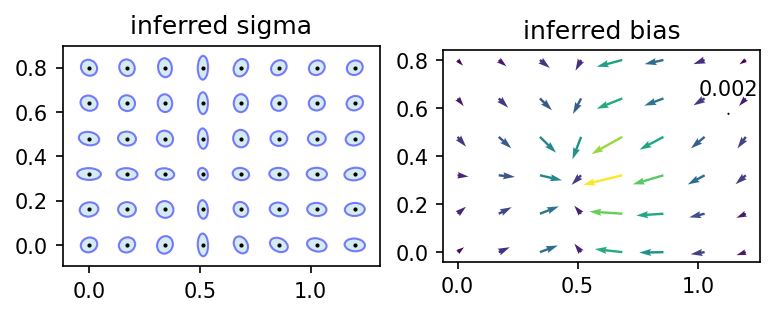

In [ ]:
ax0, ax1 = eqn.plot_control()
ax0.set_title("inferred sigma")
ax1.set_title("inferred bias");
Q = ax1.collections[0]
ax1.quiverkey(Q, 0.9, 0.7, .002, label=f"{.002}", angle=0);

# Comparison to the (reverse-time) truth

Now we'll compute the "truth" as expected based on the recorded maps,
which we first need to project into our function space.

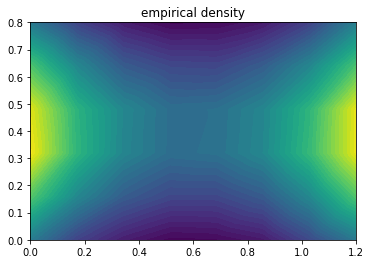

In [ ]:
density_fn = maps.xyz_to_function(empirical_maps['x'], empirical_maps['y'], empirical_maps['density'])
density = pf.transforms.callable_to_Function(lambda x, y: density_fn([[x * size, y * size]]), V)
fenics.plot(density).axes.set_title("empirical density");

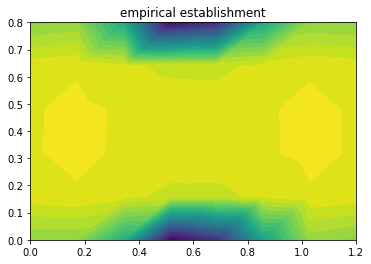

In [ ]:
establishment_fn = maps.xyz_to_function(empirical_maps['x'], empirical_maps['y'], empirical_maps['establishment'])
establishment = pf.transforms.callable_to_Function(lambda x, y: establishment_fn([[x * size, y * size]]), V)
fenics.plot(establishment).axes.set_title("empirical establishment");

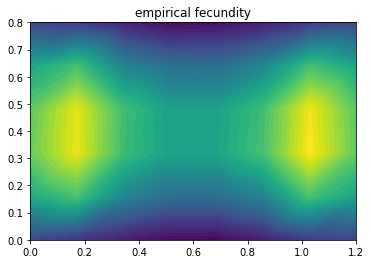

In [ ]:
fecundity_fn = maps.xyz_to_function(empirical_maps['x'], empirical_maps['y'], empirical_maps['fecundity'])
fecundity = pf.transforms.callable_to_Function(lambda x, y: fecundity_fn([[x * size, y * size]]), V)
fenics.plot(fecundity).axes.set_title("empirical fecundity");

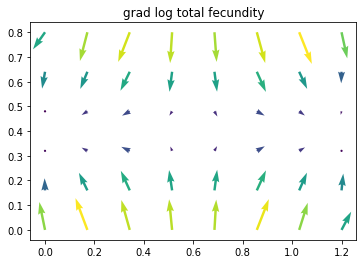

In [ ]:
log_total_fecundity = density.copy()
log_total_fecundity.vector()[:] = np.log(0.1 + density.vector()[:] * fecundity.vector()[:])
grad_log_total_fecundity = fenics.project(fenics.grad(log_total_fecundity))
fenics.plot(grad_log_total_fecundity).axes.set_title("grad log total fecundity");

In [ ]:
bias_fn_x = maps.xyz_to_function(empirical_maps['x'], empirical_maps['y'], empirical_maps['bias_x'])
bias_fn_y = maps.xyz_to_function(empirical_maps['x'], empirical_maps['y'], empirical_maps['bias_y'])
def bias_fn(x, y):
    return np.array([bias_fn_x((x, y)), bias_fn_y((x, y))])
bias = pf.transforms.vectorized_fn(V, dim=2, name='bias')
bias.vector()[:] = pf.transforms.callable_to_array(
    lambda x, y: bias_fn(x * size, y * size),
    V,
).flatten()

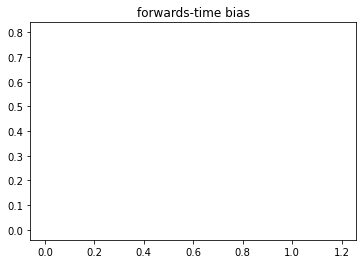

In [ ]:
fenics.plot(bias).axes.set_title("forwards-time bias");

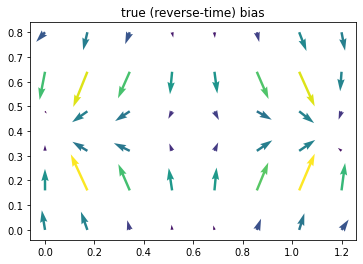

In [ ]:
true_bias = fenics.project(2 * establishment * fecundity * (grad_log_total_fecundity - bias))
fenics.plot(true_bias).axes.set_title("true (reverse-time) bias");